# Imports

In [22]:
import numpy as np
from JobsDb import JobsDb
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import calinski_harabasz_score
from matplotlib import pyplot as plt

# Load data

In [2]:
db = JobsDb()
df = db.load_table_as_df('jobs')
db.close()

In [3]:
df.head()

,id,title,url,description
0,1,Psychiatrist (Per Diem) - #201222-4667HD,https://www.careerjet.com/jobad/us61b2e1c18a4d...,\n \n shall strive to be a global leader i...
1,2,Professor of Osteopathic Manipulative Medicine,https://www.careerjet.com/jobad/us0f769e5a939c...,\nPosition Details Position Title Professor o...
2,3,Amazon Warehouse Assistant - Immediately Hiring,https://www.careerjet.com/jobad/usba95a3670331...,\n \n Hourly pay rate: $15.00 *The base pa...
3,4,Non-QM Underwriter,https://www.careerjet.com/jobad/usb59eda9438ed...,\nJob Description We looking to add an experi...
4,5,"project manager, accounting systems",https://www.careerjet.com/jobad/us71cfd31d23d6...,\njob description job summary: Project Manag...


# Extract data

In [4]:
data = df['title']

# Compute vocabulary from data

In [5]:
total_vocabulary = set(word for title in data for word in title.split(' '))

In [6]:
len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 4958 unique tokens in the dataset.


# Vectorize vocabulary using pretrained glove word embedding

In [7]:
glove = {}
with open('../model/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

# Word vectorizer class

In [8]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

# Vectorize data

In [34]:
vectorizer = W2vVectorizer(glove)
Xt = vectorizer.transform(data)

# Make k-means models for $k=3, ...,15$

In [35]:
model_list = []
for k in range(3, 16):
    model = KMeans(n_clusters = k)
    model.fit(Xt)
    model_list.append(model)

# Compute CH scores

In [36]:
CH_score = []
for model in model_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(Xt, labels))

# Plot CH scores

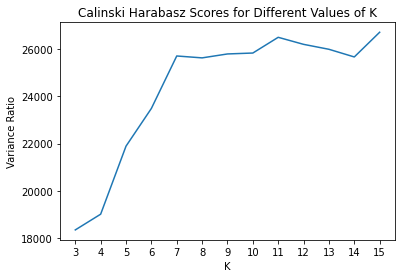

In [37]:
plt.plot(range(3,16), CH_score)
plt.xticks(range(3,16))
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K')
plt.show()

# Compute WCSS scores

In [29]:
wcss_score = []
for model in model_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

# Plot WCSS scores

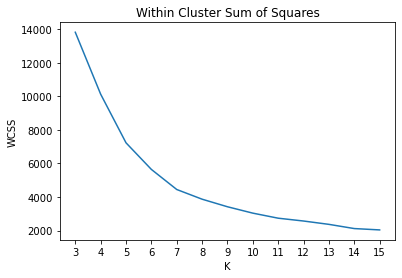

In [30]:
plt.plot(range(3,16), wcss_score)
plt.xticks(range(3,16))
plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('K')
plt.show()

# Build pipleline to execute selected model

In [31]:
pipe =  Pipeline([
    ('Word2Vec_Vectorizer', W2vVectorizer(glove)),
    ('KMeans', KMeans(n_clusters=7))])

In [32]:
pipe.fit(data)

Pipeline(steps=[('Word2Vec_Vectorizer',
                 <__main__.W2vVectorizer object at 0x7f7931dc5630>),
                ('KMeans', KMeans(n_clusters=7))])